<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/neo4j_llama_multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install llama_index neo4j torch torchvision git+https://github.com/openai/CLIP.git beautifulsoup4

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-awkrubzw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-awkrubzw
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 900.5/900.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.8/192.8 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.2 MB/s eta 0:00:00
  

In [2]:
import os
from bs4 import BeautifulSoup, NavigableString
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import Neo4jVectorStore
from llama_index import StorageContext, Document
from llama_index.schema import ImageDocument
from llama_index.node_parser import SimpleNodeParser
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
import tiktoken
import seaborn as sns
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

os.environ["OPENAI_API_KEY"] = "sk-"
NEO4J_URI=""
NEO4J_USERNAME=""
NEO4J_PASSWORD=""

# Prepare data

In [3]:
!wget https://github.com/tomasonjo/blog-datasets/raw/main/articles.zip

--2023-11-24 22:10:53--  https://github.com/tomasonjo/blog-datasets/raw/main/articles.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/articles.zip [following]
--2023-11-24 22:10:53--  https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/articles.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347398 (339K) [application/zip]
Saving to: ‘articles.zip’

articles.zip        100%[===================>] 339.26K  --.-KB/s    in 0.05s   

2023-11-24 22:10:53 (6.60 MB/s) - ‘articles.zip’ saved [347398/347398]



In [4]:
!unzip articles.zip

Archive:  articles.zip
  inflating: 2022-01-10_Exploring-the-NFT-transaction-with-Neo4j-cba80ead7e0b.html  
  inflating: 2022-01-19_Integrate-Neo4j-with-PyTorch-Geometric-to-create-recommendations-21b0b7bc9aa.html  
  inflating: 2022-01-25_Monitoring-the-Cryptocurrency-Space-with-NLP-and-Knowledge-Graphs-92a1cfaebd1a.html  
  inflating: 2022-02-22_Batching-Transactions-in-Neo4j-1001d12c9a4a.html  
  inflating: 2022-02-26_Represent-United-Kingdom-s-public-record-as-a-knowledge-graph-647b6fd07b3d.html  
  inflating: 2022-03-10_Stay-in-touch-with-the-latest-medical-research-by-utilizing-Spark-NLP-and-biomedical-knowledge--950d5ed4c758.html  
  inflating: 2022-03-21_Real-Time-Dashboard-of-Bitcoin-Transactions-With-Neo4j-and-NeoDash-ecfda0ba2c9b.html  
  inflating: 2022-05-06_Extract-knowledge-from-text--End-to-end-information-extraction-pipeline-with-spaCy-and-Neo4j-502b2b1e0754.html  
  inflating: 2022-05-22_You-can-register-the-rebel-component-only-once-53ab4c7ed98c.html  
  inflating: 2

In [5]:
def process_html_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "html.parser")

    # Find the required section
    content_section = soup.find("section", {"data-field": "body", "class": "e-content"})

    if not content_section:
        return "Section not found."

    sections = []
    current_section = {"header": "", "content": "", "source": file_path.split("/")[-1]}
    images = []
    header_found = False

    for element in content_section.find_all(recursive=True):
        if element.name in ["h1", "h2", "h3", "h4"]:
            if header_found and (current_section["content"].strip()):
                sections.append(current_section)
            current_section = {
                "header": element.get_text(),
                "content": "",
                "source": file_path.split("/")[-1],
            }
            header_found = True
        elif header_found:
            if element.name == "pre":
                current_section["content"] += f"```{element.get_text().strip()}```\n"
            elif element.name == "img":
                img_src = element.get("src")
                img_caption = element.find_next("figcaption")
                caption_text = img_caption.get_text().strip() if img_caption else ""
                images.append(ImageDocument(image_url=img_src))
            elif element.name in ["p", "span", "a"]:
                current_section["content"] += element.get_text().strip() + "\n"

    if current_section["content"].strip():
        sections.append(current_section)

    return images, sections

In [6]:
all_documents = []
all_images = []

# Directory to search in (current working directory)
directory = os.getcwd()

# Walking through the directory
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith(".html"):
            # Update the file path to be relative to the current directory
            images, documents = process_html_file(os.path.join(root, file))
            all_documents.extend(documents)
            all_images.extend(images)

text_docs = [Document(text=el.pop("content"), metadata=el) for el in all_documents]
print(f"Text document count: {len(text_docs)}")
print(f"Image document count: {len(all_images)}")

Text document count: 252
Image document count: 328


In [7]:
text_store = Neo4jVectorStore(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name="text_collection",
    node_label="Chunk",
    embedding_dimension=1536
)
image_store = Neo4jVectorStore(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name="image_collection",
    node_label="Image",
    embedding_dimension=512

)
storage_context = StorageContext.from_defaults(vector_store=text_store)

In [8]:
# Takes 10 min without GPU / 1 min with GPU on Google collab
index = MultiModalVectorStoreIndex.from_documents(
    text_docs + all_images, storage_context=storage_context, image_vector_store=image_store
)

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.
100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 79.9MiB/s]


In [9]:
from llama_index.prompts import PromptTemplate
from llama_index.query_engine import SimpleMultiModalQueryEngine

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", max_new_tokens=1500
)


qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    multi_modal_llm=openai_mm_llm, text_qa_template=qa_tmpl
)

query_str = "How do vector RAG application work?"
response = query_engine.query(query_str)
print(response)

Vector Retrieval-Augmented Generation (RAG) applications work by augmenting the response generation process of a Large Language Model (LLM) with information retrieved from a database structured to allow for fast vector-based searching. Here's how the process typically works, based on the image provided and the context information:

1. **Content Preparation**: A large corpus of documents (like a Wikipedia article as shown in the diagram) is processed by dividing the text into manageable chunks. This is known as text chunking.

2. **Vectorization**: These text chunks are then transformed into vector representations. Text is encoded into vectors using models that can capture semantic meaning in high-dimensional space.

3. **Vector Indexing**: The vectors are then indexed in a database system that supports vector indexing (such as Neo4j with its new vector index search capability). This allows for efficient retrieval of text chunks based on their vector similarity to a query.

4. **Questio

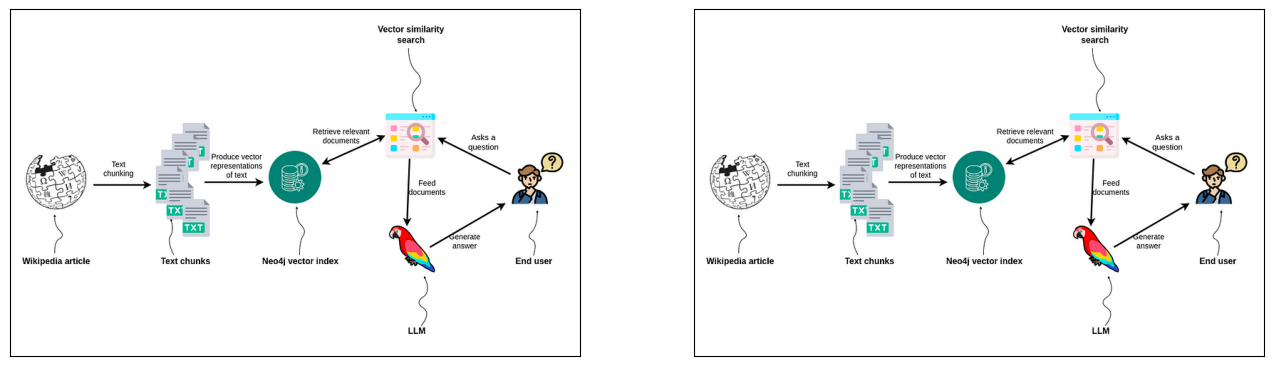

In [10]:
def plot_images(image_urls):
    images_shown = 0
    plt.figure(figsize=(25, 15))
    for img_url in image_urls:
        try:
            response = requests.get(img_url)
            response.raise_for_status()  # Raise an error for bad status codes
            image = Image.open(BytesIO(response.content))

            plt.subplot(1, 3, images_shown + 1)  # Layout adjusted for 3 images
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 3:  # Break after displaying 3 images
                break
        except Exception as e:
            print(f"Error loading image {img_url}: {e}")

plot_images([n.node.image_url for n in response.metadata["image_nodes"]])